In [2]:
import xmitgcm
import glob
from xmitgcm import open_mdsdataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
from xgcm import Grid
#import numba
matplotlib.rcParams.update({'font.size': 20})
import matplotlib.transforms as mtransforms

In [3]:
def getoutput(data_dir,prefix,step):
    l=glob.glob(data_dir+prefix+'*')
    R=[i.split('.00', 1)[1] for i in l]
    S=[i.split('.', 1)[0] for i in R]
    T=[int(i) for i in S]
    T.sort()
    iters=T[step:]
    deltaTClock = 21600.
    grid_dir = './K5000_plume/'
    data = open_mdsdataset(data_dir,grid_dir,iters=iters,delta_t=deltaTClock,prefix=prefix,geometry='sphericalpolar',default_dtype=np.dtype)
    return data

In [4]:
num=-4
lay500=getoutput('./K500/','layersDiags',num)
lay5000=getoutput('./K5000_plume/','layersDiags',num)
lay2000=getoutput('./K2000/','layersDiags',num)
lay5002=getoutput('./K500_taux2/','layersDiags',num)
lay50002=getoutput('./K5000_taux2/','layersDiags',num)
lay20002=getoutput('./K2000_taux2/','layersDiags',num)

In [5]:
num=-360
lay5002=getoutput('./K500_taux2/','layersDiags',num)

In [19]:
num=-40
dyn500=getoutput('./K500/','dyn',num)
dyn5000=getoutput('./K5000_plume/','dyn',num)
dyn2000=getoutput('./K2000/','dyn',num)
dyn5002=getoutput('./K500_taux2/','dyn',num)
dyn50002=getoutput('./K5000_taux2/','dyn',num)
dyn20002=getoutput('./K2000_taux2/','dyn',num)
dyn1000=getoutput('./K1000/','dyn',num)
dyn10002=getoutput('./K1000_taux2/','dyn',num)
dyn3000=getoutput('./K3000/','dyn',num)
dyn30002=getoutput('./K3000_taux2/','dyn',num)
dyn4000=getoutput('./K4000/','dyn',num)
dyn40002=getoutput('./K4000_taux2/','dyn',num)
lat=dyn20002.YC.values

In [16]:
num=-40
tf5002=getoutput('./K500_taux2/','Tflux',num)
tf50002=getoutput('./K5000_taux2/','Tflux',num)
tf20002=getoutput('./K2000_taux2/','Tflux',num)
tf2000=getoutput('./K2000/','Tflux',num)
tf5000=getoutput('./K5000_plume/','Tflux',num)
tf500=getoutput('./K500/','Tflux',num)
tf1000=getoutput('./K1000/','Tflux',num)
tf10002=getoutput('./K1000_taux2/','Tflux',num)
tf3000=getoutput('./K3000/','Tflux',num)
tf30002=getoutput('./K3000_taux2/','Tflux',num)
tf4000=getoutput('./K4000/','Tflux',num)
tf40002=getoutput('./K4000_taux2/','Tflux',num)

In [17]:
num=-360
dyn5002=getoutput('./K500_taux2/','dyn',num)
tf5002=getoutput('./K500_taux2/','Tflux',num)

In [23]:
sflux2=np.fromfile('./K5000_plume/sflux_drake3.bin',dtype='>f4')
sflux2=sflux2.reshape(128,64)

sst=np.fromfile('./K5000_plume/sst_wide1.bin',dtype='>f4')
sst=sst.reshape(128,64)

In [8]:
def findY(degrees):
    r=6.3781*10**6
    change=(64.5+degrees)/360
    return 2*np.pi*r*change

In [9]:
def findC(kappa,v,ys,yd,Ts,Ts1,vh):
    Td=2.667
    ISlope=findY(-40)/2000
    C2=(Ts-Td)/(-np.exp(v*yd/kappa)+np.exp(v*ys/kappa))
    C1=(((v)*(Td-(C2*np.exp(v*yd/kappa))))/ISlope)+(vh*(Ts1-Ts))
    return C1

In [10]:
def Tflux(tf):
    var=(tf['TFLUX']*tf['dxF']/1035/4200).mean('time').sum('XC')/tf['dxF'].sum('XC')
    return var

var1_500=Tflux(tf500)

In [11]:
def coverter_time(lay):
    weight=lay['dxG']
    density_to_depth = (((lay['LaHs1RHO'].mean('time')*lay['hFacS'][0]).weighted(weight)).sum('XC').cumsum('layer_1RHO_center'))/(lay['dxG'].sum('XC'))
    stream1 = (((lay['LaVH1RHO'].mean('time')*lay['hFacS'][0]).weighted(weight)).sum('XC').cumsum('layer_1RHO_center'))
    layers_depth=(lay['LaHs1RHO'].mean('time')*lay['hFacS'][0]).mean('XC').cumsum('layer_1RHO_center')
    layers_depth_atl=((lay['LaHs1RHO'].mean('time')*lay['hFacS'][0]*lay['dxG']).sum('XC')/lay['dxG'].sum('XC')).cumsum('layer_1RHO_center')
    stream1.coords['depth']=-layers_depth_atl
    layer_1RHO_center_new = xr.DataArray(layers_depth_atl, dims=['layer_1RHO_bounds','YG'], coords={'layer_1RHO_bounds': lay.layer_1RHO_bounds[:-1] ,'YG':lay.YG})
    layer2D,_=(xr.broadcast(-9.81*(lay.layer_1RHO_bounds-35)/1035, lay.YG))
    layer2D.coords['depth']=(-layer_1RHO_center_new)
    return stream1,layer2D,layers_depth

In [12]:
def density(dyn):
    buoy=(9.81*(2e-4*dyn['THETA'].mean('time')-7.4e-4*(dyn['SALT'].mean('time')-35)))
    buoy=(buoy*dyn.hFacC*dyn.dxF).sum('XC')/(dyn.hFacC*dyn.dxF).sum('XC')
    return buoy

In [14]:
def bouyFlux(dyn,Tflux):
    weights = dyn['dxF']
    numb=np.fromfile('./K500/sflux2.bin',dtype='>f4')
    run=numb.reshape(128,64)
    ra=dyn500['rA'].values
    this=np.sum(run*ra*dyn500.hFacC[0].values)
    arr=(run[:,:]-(this/np.sum(ra[:,:]*dyn500.hFacC[0].values))).astype('>f4')
    bouy=(9.81*((2e-4*Tflux['TFLUX'].mean('time')/4200/1035)-7.4e-4*(35*arr))*dyn['hFacC'][0])
    Xintegral=(bouy*bouy['dxF']*bouy['hFacC']).sum('XC')/(bouy['dxF']*bouy['hFacC']).sum('XC')
    return bouy, Xintegral

In [13]:
d500=density(dyn500)
d5000=density(dyn5000)
d2000=density(dyn2000)
d5002=density(dyn5002)
d50002=density(dyn50002)
d20002=density(dyn20002)

In [20]:
bouy2000,x2000=bouyFlux(dyn2000,tf2000)
bouy5000,x5000=bouyFlux(dyn5000,tf5000)
bouy500,x500=bouyFlux(dyn500,tf500)
bouy20002,x20002=bouyFlux(dyn20002,tf20002)
bouy50002,x50002=bouyFlux(dyn50002,tf50002)
bouy5002,x5002=bouyFlux(dyn5002,tf5002)
bouy10002,x10002=bouyFlux(dyn10002,tf10002)
bouy1000,x1000=bouyFlux(dyn1000,tf1000)
bouy30002,x30002=bouyFlux(dyn30002,tf30002)
bouy3000,x3000=bouyFlux(dyn3000,tf3000)
bouy40002,x40002=bouyFlux(dyn40002,tf40002)
bouy4000,x4000=bouyFlux(dyn4000,tf4000)

In [21]:
#model data
K1=[]
K5=[]
interps1=[]
interps5=[]


interps1.append(np.interp(0,x500.values,x500.YC.values)+64.5)
K1.append(500)

interps1.append(np.interp(0,x1000.values,x1000.YC.values)+64.5)
K1.append(1000)

interps1.append(np.interp(0,x2000.values,x2000.YC.values)+64.5)
K1.append(2000)

interps1.append(np.interp(0,x3000.values,x3000.YC.values)+64.5)
K1.append(3000)

interps1.append(np.interp(0,x4000.values,x4000.YC.values)+64.5)
K1.append(4000)

interps1.append(np.interp(0,x5000.values,x5000.YC.values)+64.5)
K1.append(5000)

interps5.append(np.interp(0,x5002.values,x5002.YC.values)+64.5)
K5.append(500)

interps5.append(np.interp(0,x10002.values,x10002.YC.values)+64.5)
K5.append(1000)

interps5.append(np.interp(0,x20002.values,x20002.YC.values)+64.5)
K5.append(2000)

interps5.append(np.interp(0,x30002.values,x30002.YC.values)+64.5)
K5.append(3000)

interps5.append(np.interp(0,x40002.values,x40002.YC.values)+64.5)
K5.append(4000)

interps5.append(np.interp(0,x50002.values,x50002.YC.values)+64.5)
K5.append(5000)

/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [24]:
#theory
yd=findY(-40)
v=-.0005
v1=-.001
lats=findY(lat[:20])
ssts=sst[:20,0]
sflux=sflux2[:20,5]
ends=np.zeros((6,20))
ends1=np.zeros((6,20))
endsB=np.zeros((6,20))
endsB1=np.zeros((6,20))
Td=2.667
Vh=np.zeros(20)
ISlope=findY(-40)/2000
for i in range(0,len(ssts)):
    Vh[i]=(var1_500[i]-((-.0005)*Td/ISlope))/(sst[i+1,0]-sst[i,0])
kappas=[500,1000,2000,3000,4000,5000]
for K in range(0,6):
    for i in range(0,20):
        ends[K,i]=findC(kappas[K],v1,lats[i],yd,ssts[i],sst[i+1,0],Vh[i]*2)
        ends1[K,i]=findC(kappas[K],v,lats[i],yd,ssts[i],sst[i+1,0],Vh[i])
        #ends[K,i]=C1/ISlope
        endsB[K,i]=(9.81*((2e-4*ends[K,i])-(7.4e-4*(35*(sflux[i])))))
        endsB1[K,i]=(9.81*((2e-4*ends1[K,i])-(7.4e-4*(35*(sflux[i])))))
span=np.zeros((len(kappas)))
spans=np.zeros((len(kappas)))
for i in range(len(kappas)):
    span[i]=np.interp(0,endsB[i],lat[:20])+64.5
    spans[i]=np.interp(0,endsB1[i],lat[:20])+64.5

/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/user/nicole.neumann-2/.conda/envs/myjup/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cac

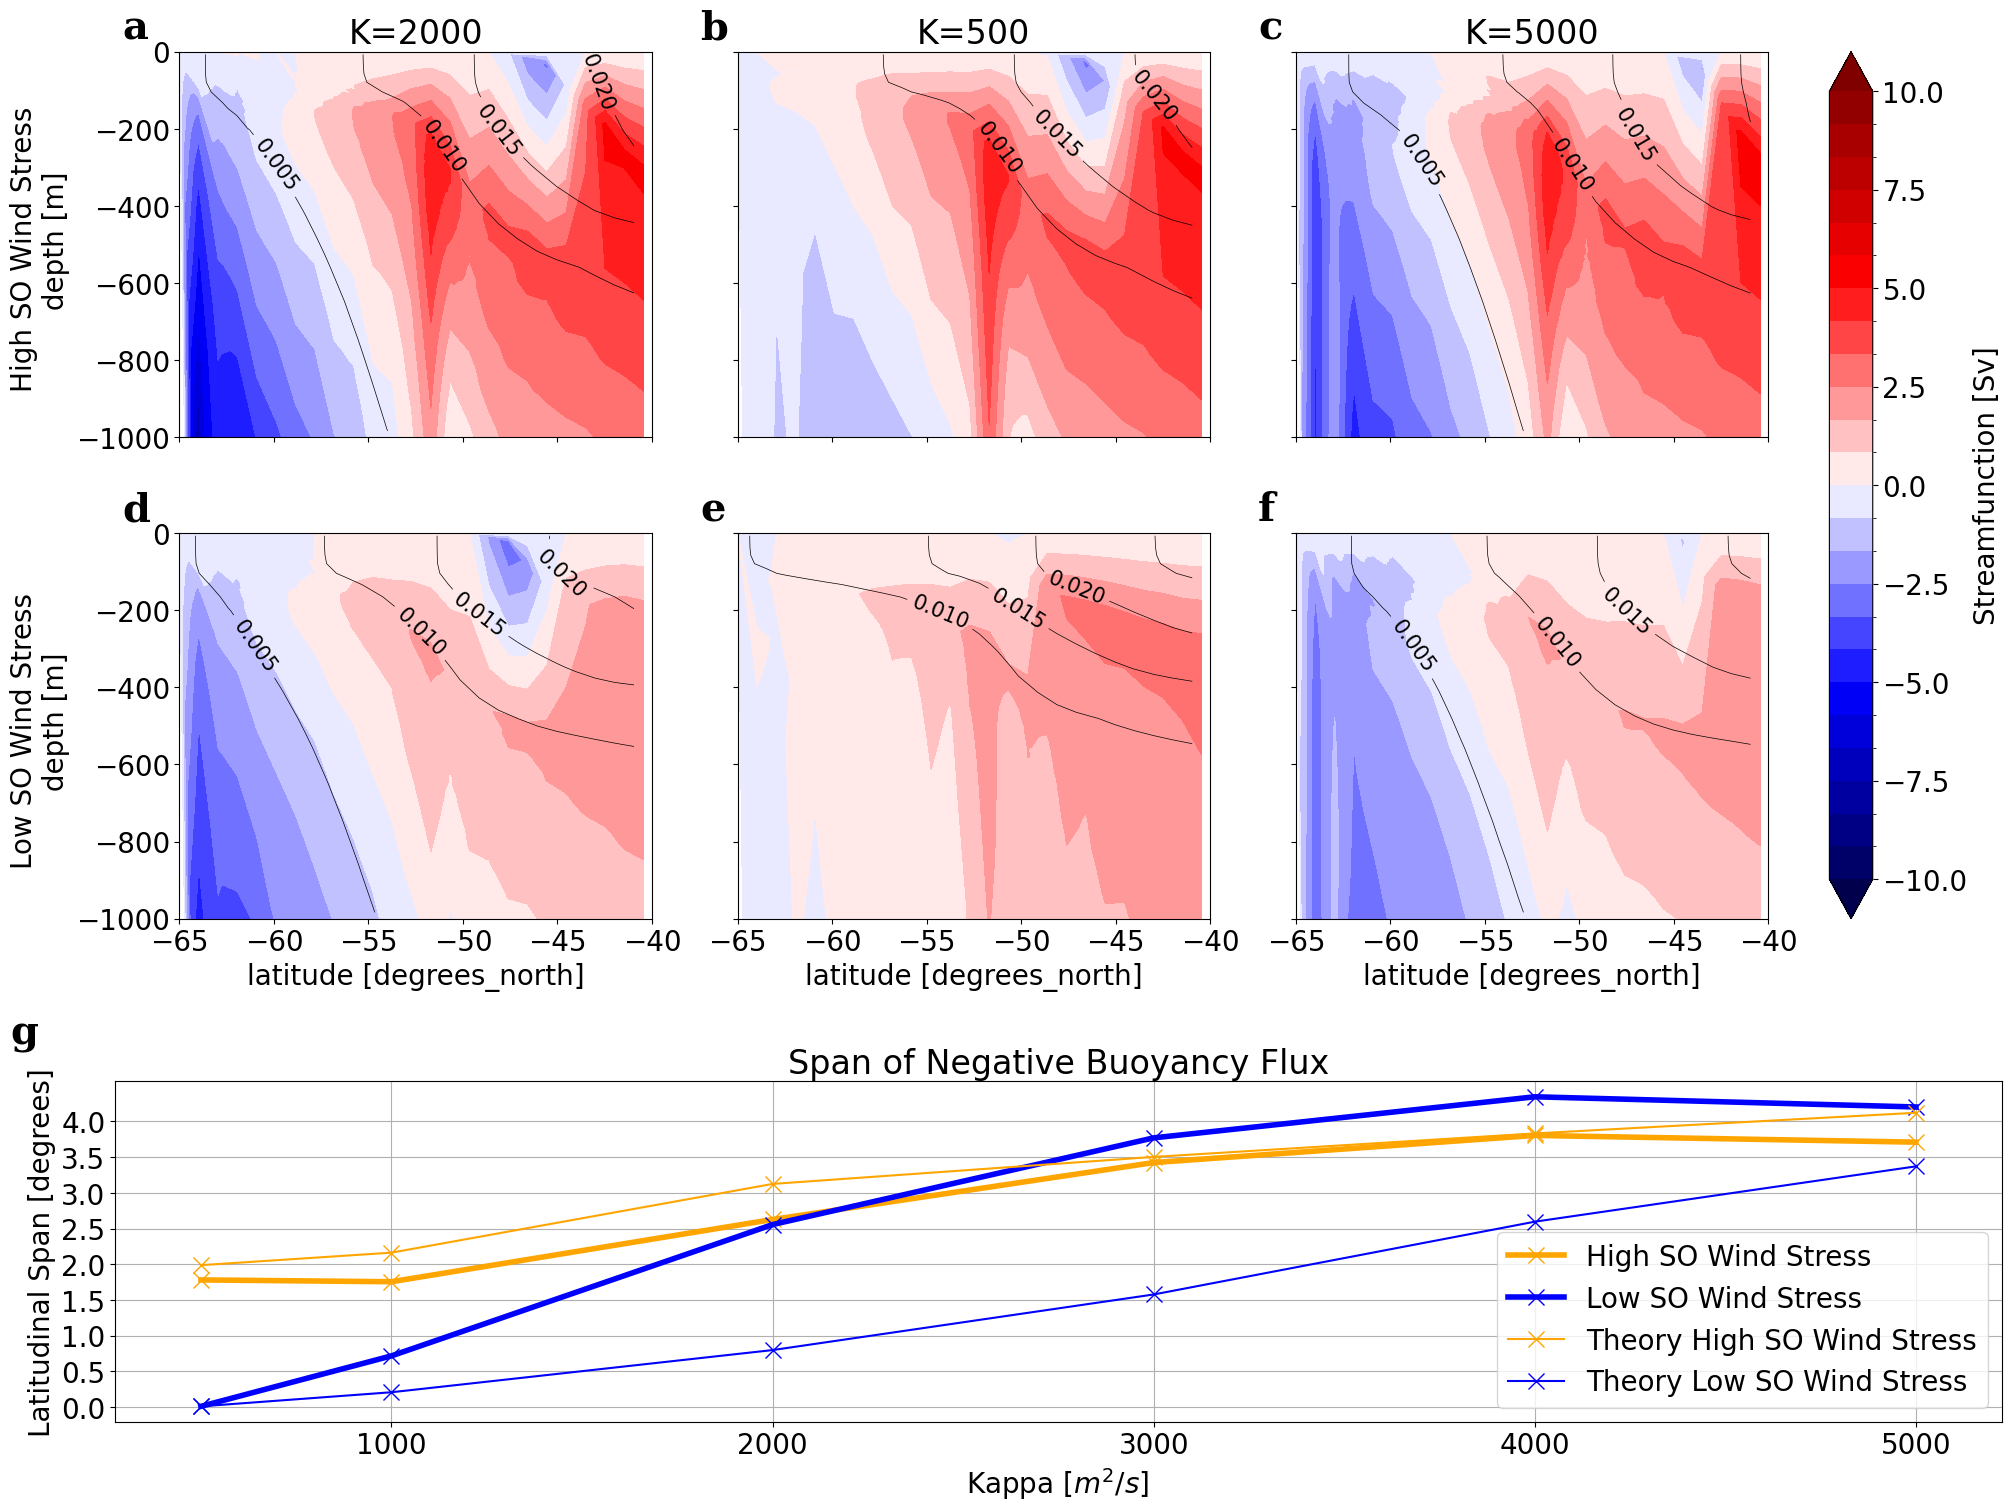

In [25]:
fig = plt.figure(layout="constrained",figsize=(20,15))
subfigs = fig.subfigures(2, 1,hspace=0.02, height_ratios=[2., 1.])


axs = subfigs[0].subplots(ncols=3,nrows=2,sharex=True)
stream5000, con5000, depth5000 = coverter_time(lay5000)

stream500, con500, depth500 = coverter_time(lay500)

stream2000, con2000, depth2000 = coverter_time(lay2000)

stream50002, con50002, depth50002 = coverter_time(lay50002)

stream5002, con5002, depth5002 = coverter_time(lay5002)

stream20002, con20002, depth20002 = coverter_time(lay20002)

cmap='seismic'
mins=-10
maxs=10

C = ((stream5000/1e6).sel(YG=slice(-70, -40))).plot.contourf(ax=axs[1,2],x='YG',y='depth',cmap=cmap,ylim=(-1000,0),add_colorbar=False,vmin=mins,vmax=maxs,extend='both',yticks=None,levels=25,yincrease=False)
cc=(d5000.sel(YC=slice(-70, -40)).sel(Z=slice(0, -1000))).plot.contour(ax=axs[1,2],x='YC',y='Z',levels=np.arange(0,0.05,0.005),colors='black',linewidths=0.5)
plt.clabel(cc, cc.levels, inline=True,  fontsize=15)
                      
C = ((stream500/1e6).sel(YG=slice(-70, -40))).plot.contourf(ax=axs[1,1],x='YG',y='depth',cmap=cmap,ylim=(-1000,0),vmin=mins,add_colorbar=False,vmax=maxs,extend='both',levels=25,yincrease=False)
cc=(d500.sel(YC=slice(-70, -40)).sel(Z=slice(0, -1000))).plot.contour(ax=axs[1,1],x='YC',y='Z',levels=np.arange(0,0.05,0.005),colors='black',linewidths=0.5)
plt.clabel(cc, cc.levels, inline=True,  fontsize=15)

C = ((stream2000/1e6).sel(YG=slice(-70, -40))).plot.contourf(ax=axs[1,0],x='YG',y='depth',cmap=cmap,ylim=(-1000,0),vmin=mins,add_colorbar=False,vmax=maxs,extend='both',levels=25,yincrease=False)
cc=(d2000.sel(YC=slice(-70, -40)).sel(Z=slice(0, -1000))).plot.contour(ax=axs[1,0],x='YC',y='Z',levels=np.arange(0,0.05,0.005),colors='black',linewidths=0.5)
plt.clabel(cc, cc.levels, inline=True,  fontsize=15)

                      
C = ((stream50002/1e6).sel(YG=slice(-70, -40))).plot.contourf(ax=axs[0,2],x='YG',y='depth',cmap=cmap,ylim=(-1000,0),add_colorbar=False,vmin=mins,vmax=maxs,extend='both',yticks=None,levels=25,yincrease=False)
cc=(d50002.sel(YC=slice(-70, -40)).sel(Z=slice(0, -1000))).plot.contour(ax=axs[0,2],x='YC',y='Z',levels=np.arange(0,0.05,0.005),colors='black',linewidths=0.5)
plt.clabel(cc, cc.levels, inline=True,  fontsize=15)

C = ((stream5002/1e6).sel(YG=slice(-70, -40))).plot.contourf(ax=axs[0,1],x='YG',y='depth',cmap=cmap,ylim=(-1000,0),vmin=mins,add_colorbar=False,vmax=maxs,extend='both',levels=25,yincrease=False)
cc=(d5002.sel(YC=slice(-70, -40)).sel(Z=slice(0, -1000))).plot.contour(ax=axs[0,1],x='YC',y='Z',levels=np.arange(0,0.05,0.005),colors='black',linewidths=0.5)
plt.clabel(cc, cc.levels, inline=True,  fontsize=15)

C = ((stream20002/1e6).sel(YG=slice(-70, -40))).plot.contourf(ax=axs[0,0],x='YG',y='depth',cmap=cmap,ylim=(-1000,0),vmin=mins,add_colorbar=False,vmax=maxs,extend='both',levels=25,yincrease=False)
cc=(d20002.sel(YC=slice(-70, -40)).sel(Z=slice(0, -1000))).plot.contour(ax=axs[0,0],x='YC',y='Z',levels=np.arange(0,0.05,0.005),colors='black',linewidths=0.5)
plt.clabel(cc, cc.levels, inline=True,  fontsize=15)


axs[0,0].set_xlim(-65,-40)

#plt.grid('on')
axs[1,1].set_yticklabels([])
axs[1,2].set_yticklabels([])
axs[0,1].set_yticklabels([])
axs[0,2].set_yticklabels([])
axs[0,0].set_title('K=2000')
axs[0,1].set_ylabel(' ')
axs[1,1].set_ylabel(' ')
axs[1,2].set_ylabel(' ')
axs[0,1].set_xlabel(' ')
axs[1,0].set_ylabel('Low SO Wind Stress \n depth [m]')
axs[0,0].set_ylabel('High SO Wind Stress \n depth [m]')
axs[0,0].set_xlabel(' ')
axs[0,2].set_ylabel(' ')
axs[0,2].set_xlabel(' ')
axs[0,2].set_title('K=5000')
axs[0,1].set_title('K=500')
#fig.tight_layout()
plt.colorbar(C,ax=axs,pad=.02,label='Streamfunction [Sv]')

axs[0,0].text(-68.0, 110.0, 'a',
            fontsize='x-large', verticalalignment='top', fontfamily='serif', fontweight='bold')
axs[0,1].text(-67.0, 110.0, 'b',
            fontsize='x-large', verticalalignment='top', fontfamily='serif',fontweight='bold')
            
axs[0,2].text(-67.0, 110.0, 'c',
            fontsize='x-large', verticalalignment='top', fontfamily='serif',fontweight='bold')
           
axs[1,0].text(-68.0, 110.0, 'd',
            fontsize='x-large', verticalalignment='top', fontfamily='serif',fontweight='bold')
            
axs[1,1].text(-67.0, 110.0, 'e',
            fontsize='x-large', verticalalignment='top', fontfamily='serif',fontweight='bold')
            
axs[1,2].text(-67.0, 110.0, 'f',
            fontsize='x-large', verticalalignment='top', fontfamily='serif',fontweight='bold')
            

axs1 = subfigs[1].subplots(ncols=1,nrows=1)
axs1.plot(K5,interps5,label='High SO Wind Stress',marker='x',linewidth=4,color='orange',markersize=12)
axs1.set_yticks(np.arange(0,4.5,0.5))
axs1.plot(K1,interps1,label='Low SO Wind Stress',marker='x',linewidth=4,color='blue',markersize=12)
axs1.plot(kappas,span,label='Theory High SO Wind Stress',marker='x',color='orange',markersize=12)
axs1.plot(kappas,spans,label='Theory Low SO Wind Stress',marker='x',color='blue',markersize=12)
axs1.grid(True)
axs1.legend()
axs1.set_ylabel('Latitudinal Span [degrees]')
axs1.set_xlabel(r'Kappa $[m^2/s]$ ')
axs1.set_title('Span of Negative Buoyancy Flux')

axs1.text(-1, 5.5, 'g',
            fontsize='x-large', verticalalignment='top', fontfamily='serif',fontweight='bold')
     

plt.savefig("layers.png")